---
title: Random Forest Based Land-Cover Mapping with Sentinel-2
subtitle: Demonstrate how to perform a basic land cover mapping using random forest and the Sentinel-2 data in EOPF Zarr format
authors:
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-09-11
thumbnail: ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
keywords: ["data access", "xarray", "EOPF Zarr products"]
tags: ["sentinel-2", "xcube", "land"]
releaseDate: 2025-09-11
datePublished: 2025-09-11
dateModified: 2025-09-11
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of Contents

1. [Introduction](#Introduction_RF)
2. [Training Dataset Generation](#training_RF)
2. [Sample points selection](#Sample_sel_RF)
3. [Read the points in Python](#read_points_RF)
4. [Satellite data retrieval](#data_RF)
5. [Predictors/Features extraction](#predictors_RF)
6. [Random Forest](#random_forest_RF)
7. [Model training](#model_training_RF)
8. [Model prediction](#model_predict_RF)
9. [Prediction Evaluation](#evaluation_RF)
10. [What's next?](#next_RF)

(Introduction_RF)=
## Introduction

In this notebook, we will explore **land cover mapping**, a practice that has been integral to remote sensing since its inception. **Land cover products are essential for studying the functional and morphological changes in Earth's ecosystems and the environment**, playing a crucial role in understanding climate change and carbon circulation (Congalton et al., 2014; Feddema et al., 2005; Sellers et al., 1997). Additionally, land cover mapping provides valuable information for policy development and a wide range of applications within the natural and life sciences, making it one of the most extensively studied applications in remote sensing (Yu et al., 2014; Tucker et al., 1985; Running, 2008; Yang et al., 2013).
The diverse applications of land cover mapping lead to varied user needs. Depending on the specific use case, there can be significant differences in the desired target labels, the requested target year(s), the required output resolution, the feature set used, the stratification strategy employed, and more.

This exercise demonstrates how to efficiently use the Sentinel-2 EOPF Zarr products to implement a basic land cover classification.

:::{hint} Overview
**Questions**
- How do we create a training set using EOPF Zarr Sentinel-2 data?
- How can we extract samples using vector data (points)?
- How do we apply a Random Forest model to predict the land cover

**Objectives**
- Learn how to extract and use data from the EOPF Sentinel Zarr Samples catalogue to prepare a training set
- Create and train your own Random Forest model to predict land cover based on Sentinel-2 data
:::

Install the missing libraries

In [1]:
pip install xgboost contextily

Note: you may need to restart the kernel to use updated packages.


(training_RF)=
## Training Dataset Generation

In this exercise, we will focus on 4 main classes:
1. artificial surfaces
2. agricultural areas
3. forests and seminatual areas
4. water bodies

The names of these classes comes from Corine Land Cover Level 0 classification scheme: https://wiki.openstreetmap.org/wiki/Corine_Land_Cover

(Sample_sel_RF)=
### Sample points selection

Generate 4 geoJSON files containing at least 10 points for each class using the website: https://geojson.io/#map=12/46.48882/11.33004

Follow this procedure for each land cover class:
1. Open the link: https://geojson.io/#map=12/46.48882/11.33004
2. Switch to satellite view selecting "Standard Satellite" as a base layer in the bottom left corner
3. Select the Draw Point tool and place a point in an area corresponding to the class
4. Repeat until you have at least 10 points
5. Save the geoJSON file with the top-left toolbar
6. Repeat for the other classes

Once that you have your 4 .geojson files, upload them to JupyterLab via drag & drop.  

If you don't want to do this small mapping exercise and skip directly to the next part, we prepared already the necessary files for the area of Bolzano, Italy.

(read_points_RF)=
### Read the points in Python

Modify the file paths to match the files that you generated

In [2]:
urban_points_file = "./geojson/urban.geojson"
crops_points_file = "./geojson/crop.geojson"
forest_points_file = "./geojson/forest.geojson"
water_points_file = "./geojson/water.geojson"

Use GeoPandas to read the vector data. We also assign the corresponding Corine Land Cover code.

In [3]:
import geopandas as gpd
import numpy as np

df_urban = gpd.read_file(urban_points_file).assign(**{"label": 100})
df_crops = gpd.read_file(crops_points_file).assign(**{"label": 200})
df_forest = gpd.read_file(forest_points_file).assign(**{"label": 300})
df_water = gpd.read_file(water_points_file).assign(**{"label": 500})

ERROR 1: PROJ: proj_create_from_database: Open of /home/mclaus@eurac.edu/micromamba/envs/eopf-zarr/share/proj failed


Inspect a GeoDataFrame object containing the sample points

In [4]:
df_urban.head(3)

,geometry,label
0,POINT (11.32883 46.48775),100
1,POINT (11.34056 46.49088),100
2,POINT (11.33035 46.4911),100


Visualize a set of points to check if they are placed correctly on the corresponding class:

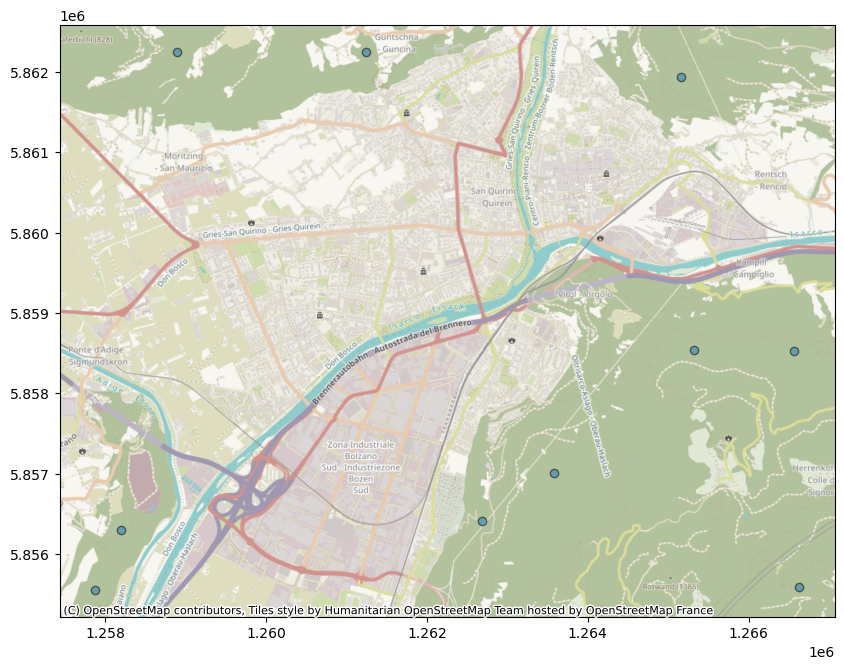

In [5]:
import contextily as cx

df_wm = df_forest.to_crs(epsg=3857)  # Points placed on forests
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax)

(data_RF)=
### Satellite data retrieval

We will use optical Sentinel-2 data from the months of June, July and August 2022.

The data is available via the public EOPF Zarr STAC Catalog, available at https://stac.core.eopf.eodc.eu .

The [xcube-eopf](github.com/EOPF-Sample-Service/xcube-eopf) package will handle the STAC API requests and the datacube building parts.

In [6]:
from xcube.core.store import new_data_store
from xcube_eopf.utils import reproject_bbox

In [7]:
store = new_data_store("eopf-zarr")

We would like to extract the bounds of the area containing our training points.

To do that we can combine the different GeoDataFrames into a single one and use the `total_bounds` method.

In [8]:
import pandas as pd

sample_points = pd.concat([df_urban, df_crops, df_forest, df_water])
bbox = sample_points.total_bounds
crs_utm = "EPSG:32632"  # If you select the points in a different part of the World, you might need to use a different CRS
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_utm)
bbox_utm

(676214.7067171357, 5147669.36589368, 682626.7086097527, 5153320.106294904)

In [9]:
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2025-06-01", "2025-08-31"],
    spatial_res=10,
    crs=crs_utm,
    variables=[
        "b04",
        "b03",
        "b02",
        "b08",
        # "scl"
    ],  # b04 = red, b03 = green, b02 = blue, b08 = near infrared
)
ds

<xarray.Dataset> Size: 373MB
Dimensions:      (time: 32, y: 567, x: 642)
Coordinates:
  * time         (time) datetime64[ns] 256B 2025-06-01T10:10:41.025000 ... 20...
    spatial_ref  int64 8B ...
  * x            (x) float64 5kB 6.762e+05 6.762e+05 ... 6.826e+05 6.826e+05
  * y            (y) float64 5kB 5.153e+06 5.153e+06 ... 5.148e+06 5.148e+06
Data variables:
    b02          (time, y, x) float64 93MB dask.array<chunksize=(1, 567, 642), meta=np.ndarray>
    b03          (time, y, x) float64 93MB dask.array<chunksize=(1, 567, 642), meta=np.ndarray>
    b04          (time, y, x) float64 93MB dask.array<chunksize=(1, 567, 642), meta=np.ndarray>
    b08          (time, y, x) float64 93MB dask.array<chunksize=(1, 567, 642), meta=np.ndarray>
Attributes: (4)

Perform a temporal aggregation to get a monthly median of the data.

**The median is capable to filter out data extremes, like clouds.  
However, to get the best result is advisable to create and apply a cloud mask using the Scene Classification Layer, can you add this step before computing the median?**  

You can have a look at the example provided here: https://eopf-sample-service.github.io/eopf-sample-notebooks/sentinel-2-ndsi-snow-mapping/#cloud-snow

Remember to add the "scl" band when creating the datacube and to remove it before performing the feature extraction.

In [10]:
# Apply the cloud mask to the data here:

In [11]:
monthly_median = ds.groupby("time.month").median().to_dataarray(dim="bands")
monthly_median

<xarray.DataArray (bands: 4, month: 3, y: 567, x: 642)> Size: 35MB
dask.array<stack, shape=(4, 3, 567, 642), dtype=float64, chunksize=(1, 1, 567, 642), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B ...
  * x            (x) float64 5kB 6.762e+05 6.762e+05 ... 6.826e+05 6.826e+05
  * y            (y) float64 5kB 5.153e+06 5.153e+06 ... 5.148e+06 5.148e+06
  * month        (month) int64 24B 6 7 8
  * bands        (bands) object 32B 'b02' 'b03' 'b04' 'b08'
Attributes: (4)

The default area above Bolzano corresponds to a manageable datacube which can fit easily in memory and therefore we will now load it in memory to speed up the next steps.

In [12]:
monthly_median = monthly_median.compute()

/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr/lib/python3.11/site-packages/dask/_task_spec.py:758: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


Visualize a sample image of the selected ones:

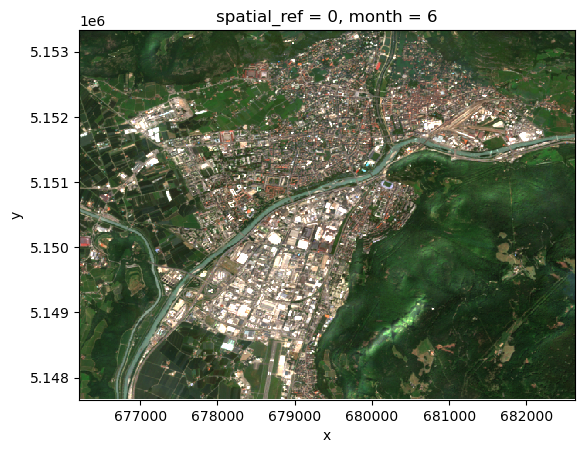

In [13]:
monthly_median.loc[dict(bands=["b04", "b03", "b02"])][:, 0].plot.imshow(
    vmin=0, vmax=0.25
)

(predictors_RF)=
### Predictors/Features extraction

Given the selected sample points and the Sentinel-2 data, we can now extract the data values corresponding to each sample point.

Each data array extracted will become a so-called `predictor` or `feature` vector.

#### Points - Data projection alignment

The geoJSON files contain points with coordinates expressed in lat/lon (WGS84 / EPSG:4326 coordinate system).

However, the data doesn't necessarily has the same projection.
Therefore, we reproject points to match data projection.

In [14]:
monthly_median.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]')

In [15]:
sample_points_reproj = sample_points.to_crs(monthly_median.rio.crs)

#### Feature Vector extraction

Given the reprojected points we can get the corresponding values and create feature vectors, which will be used for training.

We store the feature vectores in the same GeoDataFrame as the sampled points:

In [16]:
predictors = []
for idx, s in enumerate(sample_points_reproj.iterrows()):
    point = s[1]["geometry"]
    data_values = monthly_median.sel(x=point.x, y=point.y, method="nearest").values
    feature_vector = np.ndarray.flatten(data_values)
    predictors.append(feature_vector)
sample_points_reproj = sample_points_reproj.assign(**{"features": predictors})
sample_points_reproj

,geometry,label,features
0,POINT (678733.219 5150876.795),100,"[0.0658, 0.3066, 0.05885, 0.09410000000000002,..."
1,POINT (679623.239 5151251.375),100,"[0.0751, 0.4092, 0.039900000000000005, 0.0948,..."
2,POINT (678838.582 5151252.833),100,"[0.1016, 0.2952, 0.0734, 0.1142, 0.28559999999..."
3,POINT (679075.269 5150069.496),100,"[0.35520000000000007, 0.4176000000000001, 0.35..."
4,POINT (678776.558 5149460.191),100,"[0.21520000000000003, 0.31679999999999997, 0.1..."
5,POINT (679886.342 5150460.642),100,"[0.0703, 0.3588, 0.061450000000000005, 0.0865,..."
6,POINT (678047.754 5150715.131),100,"[0.0942, 0.2488, 0.07164999999999999, 0.100200..."
7,POINT (678261.919 5149167.079),100,"[0.1084, 0.344, 0.0821, 0.122, 0.3364000000000..."
8,POINT (680532.627 5152198.803),100,"[0.0834, 0.2994, 0.0597, 0.0965, 0.30200000000..."
9,POINT (681050.795 5152361.76),100,"[0.0816, 0.259, 0.08430000000000001, 0.09, 0.2..."


We perform some operations to:
1. Get the feature vector in the desired shape: NxM with N as the number of points and M the number of features (in this case bands*time)
2. Get the corresponding label vector with the correct format. The ML library we are using is expecting labels with values starting from 0 and therefore we have to map them.

In [17]:
dict_mapping = {}
[
    dict_mapping.update({x: lbl})
    for x, lbl in enumerate(np.unique(sample_points_reproj["label"].values))
]
dict_mapping

{0: 100, 1: 200, 2: 300, 3: 500}

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(sample_points_reproj["label"].values)
x_train = np.asarray([x for x in sample_points_reproj["features"].values])

(random_forest_RF)=
## Random Forest

We use the xgboost ML library with its Random Forest implementation.

For more info please read the documentation here:

https://xgboost.readthedocs.io/en/stable/tutorials/rf.html#standalone-random-forest-with-scikit-learn-like-api

and for the colsample_by* hyperparameters explanation check this nice article here:

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

(model_training_RF)=
### Model training

In [19]:
from xgboost import XGBRFClassifier

model = XGBRFClassifier(n_estimators=100, subsample=0.9)
model.fit(x_train, y_train)

,learning_rate,1.0
,subsample,0.9
,colsample_bynode,0.8
,reg_lambda,1e-05
,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bytree,None
,device,None


(model_predict_RF)=
### Model prediction

To speed up the prediction process, we parallelize using xarray `apply_ufunc`, which allows to apply the same function call to multiple data chunks in parallel using Dask.

In [20]:
import xarray as xr


def predict_rf(x):
    d = np.reshape(x, (x.shape[0] * x.shape[1], x.shape[2] * x.shape[3]))
    pred = model.predict(d)
    return np.reshape(pred, (x.shape[0], x.shape[1]))


def predict(obj, dims):
    return xr.apply_ufunc(
        predict_rf,
        obj,
        input_core_dims=[dims],
        dask="parallelized",
        output_dtypes=[int],
    )


predicted = predict(monthly_median, ["bands", "month"])

(evaluation_RF)=
## Prediction Evaluation

Now that our model has been trained and the prediction generated based on it, we can evaluate the result.

We didn't do any split of the training set due to the limited number of samples, so we don't have any test or validation set to use.

For this simple example, please evaluate the result using QGIS (or equivalent GIS software) and a satellite layer as a reference.

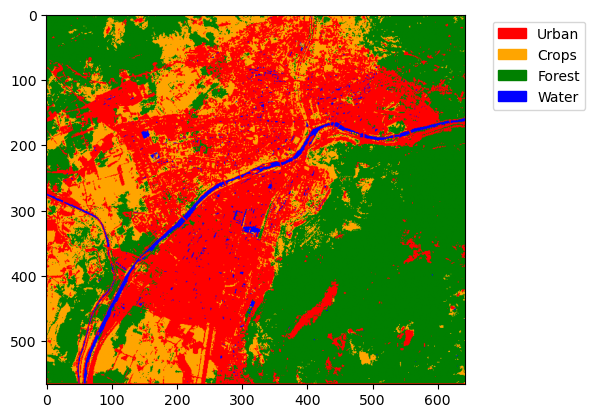

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

class_labels = {0: "Urban", 1: "Crops", 2: "Forest", 3: "Water"}

# Define a colormap with as many colors as classes
cmap = mcolors.ListedColormap(["red", "orange", "green", "blue"])

# Define normalization: boundaries between class values
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]  # half-way between class values
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Show the image
plt.imshow(predicted.values, cmap=cmap, norm=norm)

# Build custom legend
patches = [
    mpatches.Patch(color=cmap(i), label=label)
    for i, label in enumerate(class_labels.values())
]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

(next_RF)=
## What's next?

Now that you learned the basics, you can try to:

- Create and apply a cloud mask to the data in the [Satellite data retrieval](#data_RF) section.
- Apply the model to a new, unseen location and evaluate the results.
- Apply the model to a different year compared to the training set.

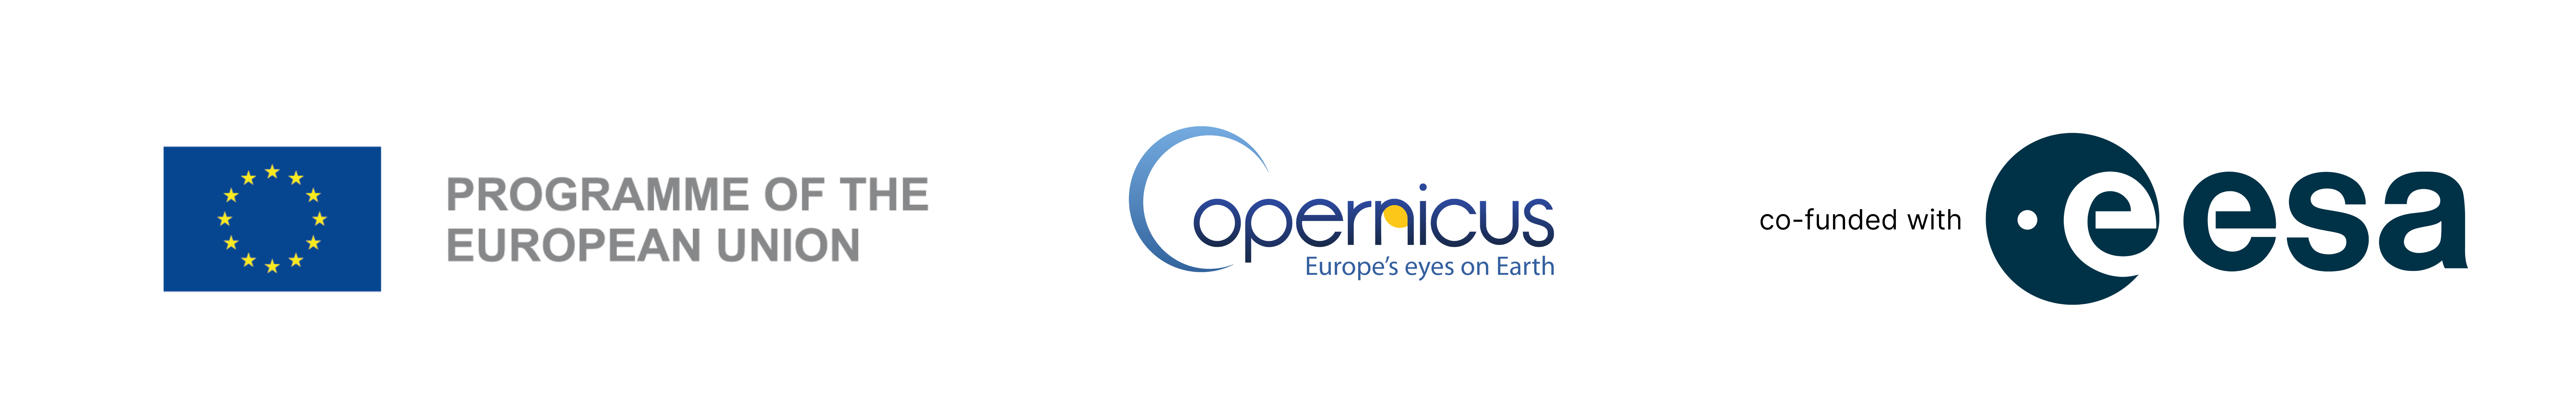